In [1]:
import sys
import os
import pandas as pd

from sklearn import set_config
set_config(transform_output = "pandas")

# Custom utils
PROJECT_ROOT = '../'
MODEL_PATH = os.path.join(PROJECT_ROOT,'models','LogReg__ANN_RF_SVM')
sys.path.append(PROJECT_ROOT)
from scripts.data_utils import load_downsampled_df, load_full_df, get_train_validation_df, test_train_validation_split
from scripts.Ensemble_Functions import load_constituent_models, load_constituent_pipelines, ModelPredictor
from models.ANN.functions import ANN_predict_proba
from models.RF.functions import RF_predict_proba
from models.SVM.functions import SVM_predict
from models.LogReg__ANN_RF_SVM.functions import get_predictions_pipeline

In [2]:
## Load models ##

# Define model and preprocessing pipeline paths
ANN_model_path = os.path.join(PROJECT_ROOT,'models','ANN','ANN.h5')
ANN_pipe_path = os.path.join(PROJECT_ROOT,'models','ANN','ANN_preprocess_pipeline.joblib')
RF_model_path = os.path.join(PROJECT_ROOT,'models','RF','RF_model.joblib')
RF_pipe_path = os.path.join(PROJECT_ROOT,'models','RF','RF_preprocess_pipeline.joblib')
SVM_model_path = os.path.join(PROJECT_ROOT,'models','SVM','SVM_model.joblib')
SVM_pipe_path = os.path.join(PROJECT_ROOT,'models','SVM','SVM_preprocessing_pipeline.joblib')

# Load models and pipelines
models = load_constituent_models(ANN_model_path,RF_model_path,SVM_model_path)
ANN_model = models[ANN_model_path]
RF_model = models[RF_model_path]
SVM_model = models[SVM_model_path]

pipelines = load_constituent_pipelines(ANN_pipe_path,RF_pipe_path,SVM_pipe_path)
ANN_pipeline = pipelines[ANN_pipe_path]
RF_pipeline = pipelines[RF_pipe_path]
SVM_pipeline = pipelines[SVM_pipe_path]

# Freeze the ANN model
for layer in ANN_model.layers:
    layer.trainable = False

In [52]:
# Load and split data

main_df = load_downsampled_df(PROJECT_ROOT)
validation_df, test_train_df = get_train_validation_df(main_df)
X_train, X_test, X_validation, y_train, y_test, y_validation = test_train_validation_split(validation_df,test_train_df)

X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
X_validation.reset_index(drop=True,inplace=True)

In [4]:
## Create model predictors ##

ann_predictor = ModelPredictor(ANN_model, ANN_pipeline, ANN_predict_proba, 'ANN')
rf_predictor = ModelPredictor(RF_model, RF_pipeline, RF_predict_proba, 'RF')
svm_predictor = ModelPredictor(SVM_model,SVM_pipeline,SVM_predict, 'SVM')

In [8]:
## Create the predictions features ##

create_predictions_pipeline = get_predictions_pipeline(ann_predictor,rf_predictor,svm_predictor)

In [50]:
## Get training set features (constituent model predictions). Optionally, load from csv instead

#X_train_predictions = create_predictions_pipeline.transform(X_train.reset_index(drop=True))
X_train_predictions = pd.read_csv(os.path.join(PROJECT_ROOT,'data','predictions','X_train_ANN-RT-SVM-XGB_downsample.csv')).drop(columns={'Unnamed: 0','XGB_Prediction'})

In [53]:
## Final Classifier
from sklearn.linear_model import LogisticRegression

stacking_classifier = LogisticRegression(
    C=10,
    class_weight=None,
    penalty='l1',
    solver='liblinear',
    random_state=42)

stacking_classifier.fit(X_train_predictions,y_train)

LogisticRegression(C=10, penalty='l1', random_state=42, solver='liblinear')

In [ ]:
## Save final model
from joblib import dump

dump(stacking_classifier,os.path.join(MODEL_PATH,'LogReg__ANN_RF_SVM.joblib'))

**Evaluation**

In [19]:
from scripts.Visualization_functions import generate_visualizations, print_metrics, plot_roc_curve

In [57]:
# Get the validation dataset
main_df = load_full_df(PROJECT_ROOT)
validation_df, test_train_df = get_train_validation_df(main_df)
_, X_test, X_validation, _, y_test, y_validation = test_train_validation_split(validation_df,test_train_df)

In [58]:
# Get Predictions

#X_val_predictions = create_predictions_pipeline.transform(X_validation.reset_index(drop=True))
X_val_predictions = pd.read_csv(os.path.join(PROJECT_ROOT,'data','predictions','X_val_ANN-RT-SVM.csv')).drop(columns={'Unnamed: 0'})
y_pred_proba = stacking_classifier.predict_proba(X_val_predictions)[:,1]

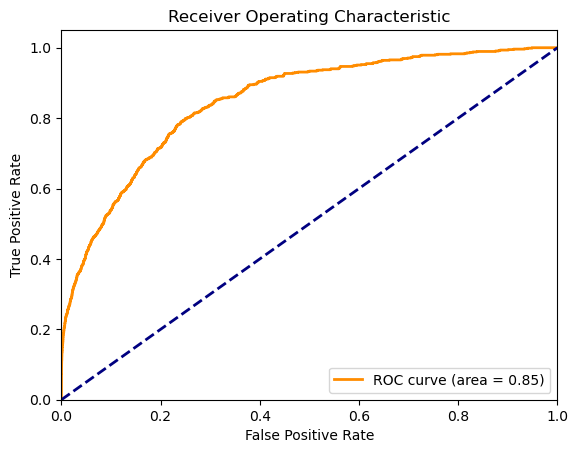

In [59]:
plot_roc_curve(y_validation, y_pred_proba)

In [62]:
thresh = 0.9
y_val_pred = (y_pred_proba > thresh).astype(int)
generate_visualizations(X_validation,y_val_pred,y_validation,main_df,os.path.join(MODEL_PATH,"LogReg_Visuals"))

In [61]:
thresh = 0.9
y_val_pred = (y_pred_proba > thresh).astype(int)
print_metrics(y_validation,y_val_pred)

Validation set accuracy: 0.995276402525905
f1 score:  0.18546845124282982
Precision: 0.3299319727891156
Recall: 0.12898936170212766


In [64]:
# Save validation probabilities
import numpy as np

np.save(os.path.join(MODEL_PATH,'LogReg_stack_y_val_proba.npy'),y_pred_proba)

**Hyperparameter and Model Tuning**

In [10]:
## Initial Grid Search ##
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer
from sklearn.linear_model import LogisticRegression
import numpy as np

# Classifier
stacking_classifier = LogisticRegression(random_state=42)

# Define StratifiedKFold to handle class imbalance during cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#F1 scorer
f1 = make_scorer(f1_score , average='macro')

param_grid = {
    'penalty': ['l1', 'l2'],  # Consider just L1 and L2
    'C': np.logspace(-3, 3, 7),  # Less granular range for C
    'solver': ['liblinear', 'saga'],  # Focus on potentially faster solvers
    'class_weight': [None, 'balanced']  # Keep the class weight options
}


# Perform grid search
grid_search = GridSearchCV(stacking_classifier, param_grid, cv=stratified_kfold, scoring=f1,n_jobs=4,verbose=3)
grid_search.fit(X_train_predictions,y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print(f"F1 Score: {100*grid_search.best_score_:.2f}%")

# Get the best pipeline
best_ensemble_pipeline = grid_search.best_estimator_

#GS1
#Fitting 5 folds for each of 56 candidates, totalling 280 fits
#Best parameters: {'C': 10.0, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
#F1 Score: 79.50%

Fitting 5 folds for each of 56 candidates, totalling 280 fits
Best parameters: {'C': 10.0, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
F1 Score: 79.50%
